In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

There are a *lot* of different clustering methods – we're going to review just three more here: _Mean-shift_, _Spectral Clustering_, and _Affinity Propagation_.  If you want to go even broader, check out this [comparison among all the clustering algorithms available in sklearn](http://scikit-learn.org/stable/modules/clustering.html).

For all three methods, we'll be using the same simulated dataset, with three "blobs."  We won't need to normalize the data since it is simulated and comes pre-normalized, but with real data normalization will be important to make sure all your features are given equal weight in finding a clustering solution.

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


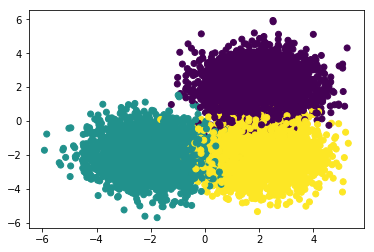

In [2]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

# The coordinates of the centers of our blobs.
centers = [[2, 2], [-2, -2], [2, -2]]

# Make 10,000 rows worth of data with two features representing three
# clusters, each having a standard deviation of 1.
X, y = make_blobs(
    n_samples=10000,
    centers=centers,
    cluster_std=1,
    n_features=2,
    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

# Mean-shift

Mean-shift, like $k$-means, is a clustering algorithm with a name that tells us what it does. It works by first calculating the probability that a data point will be present at any point in the n-dimensional space defined by the number of features. You can visualize these probabilities as a surface having hills that "peak" where many data points are present, and flat areas or valleys where few data points are present. The "peaks" represent what will become the cluster means. This surface of probabilities is called a _kernel density surface_.

Mean-shift is an iterative algorithm. At each iteration, each data point is shifted a tiny bit "up" the nearest hill.  If a data point is already at the peak, it stays where it is.  Once all data points have reached the point where they are at peaks and all further shifts (if any) are smaller than a given threshold, the algorithm terminates.  The data points are then assigned a "cluster" based on their peak.

You may notice that nothing in this definition says how high or big a hill in the surface has to be to qualify as a "peak".  Think of mountains circled by smaller foothills – does each foothill count as its own peak, or are they just part of the hill toward the higher mountain peak?

Mean-shift defines peaks using a user-defined input parameter called "bandwidth" that ranges from 0 to 1. Higher bandwidths create a smoother kernel density surface, leading to fewer peaks because smaller hills are smoothed out, whereas lower bandwidths lead to a surface with more peaks – the same peaks spotted by the higher bandwidth, plus some lower peaks.

Mean shift makes no assumptions about the nature of the data or the number of clusters, making it more versatile than $k$-means – though like $k$-means, it creates clusters where data points form an n-dimensional "globe" around a central point.  It works for data sets where many clusters are suspected. Again unlike $k$-means, clusters don't have to be the same size, and can have non-flat geometry, meaning clusters based on $m$ features that cannot be separated by a straight line or plane in the $m$-dimensional space. You may recall the concept of non-flat geometry from the lesson on the kernel trick used by SVM. However, mean shift is slow (runtime increases with the square of the size of the input) so it is recommended for small to medium-sized datasets only.

Another cool thing about mean shift is that if a point is too far away from the peaks, it may not be assigned to any cluster at all. This will depend on the threshold and number of iterations allowed. All of the other methods we review here, and $k$-means before, will assign _all_ data points to clusters, no matter how poorly suited to clustering some are.

If you don't know how many clusters you are looking for, or you suspect your clusters are heterogeneous in size or shape, and you're working with a small enough data set, mean-shift may be a good choice.

Here are [some great animations of mean shift clustering in action](https://spin.atomicobject.com/2015/05/26/mean-shift-clustering/).

Let's look at some mean shift code.

In [3]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 3


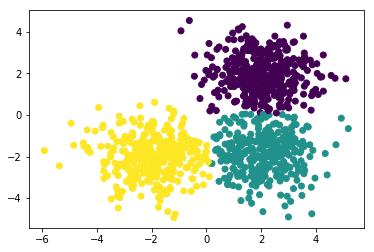

Comparing the assigned categories to the ones in the data:
col_0    0    1    2
row_0               
0      352   10    0
1        1    8  311
2        6  304    8


In [4]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

Not bad at all.

## Spectral clustering

Spectral clustering (and affinity propagation, which we cover next) is based on quantifying similarity between data points – pixels in an image that are nearby or part of the same texture, people in a social network that share a category (friends, family), or words that often appear in the same context would all be types of "similarity" potentially detectable by these algorithms.

Spectral clustering defines a similarity matrix of *n x n* dimensions, where *n* is the number of data points in the dataset.  The matrix is made up of indices of similarity for every pairwise combination of data points. Then, a transformation matrix is applied to calculate a set of eigenvectors with appropriate eigenvalues. In other words, this is PCA on a similarity matrix rather than a covariance matrix.

The spectral clustering algorithm can take many different measures of similarity (also called affinity). Two common ones are "nearest neighbors", which you may recall from the assignment on KNN in the supervised learning lesson, and the Gaussian kernel of the Euclidean distance (called radial basis function or "rbf" in sklearn). We can provide any kernel function that computes pairwise similarity with 0 meaning no similarity and higher numbers indicating greater similarity.

The user provides the number of clusters desired, $k$. The $k$ eigenvectors with the $k$ largest eigenvalues are extracted and the data is converted to the new $k$-dimensional space.  The $k$-means algorithm is then applied to the new $k$-dimensional data to extract $k$ clusters.

Like $k$-means, spectral clustering is slow and works best when $k$ is not too large and clusters are equal in size.  Unlike $k$-means, the dimension reduction aspect of spectral clustering means that it can identify clusters with non-flat geometry, and clusters are not necessarily globular in the original dimensional space.

Time for code.

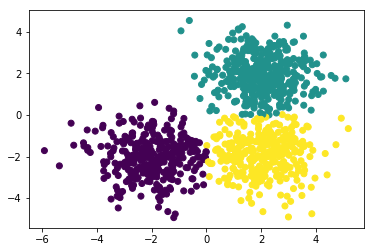

Comparing the assigned categories to the ones in the data:
col_0    0    1    2
row_0               
0        0  357    5
1      310    1    9
2        5    7  306


In [5]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

These clusters look familiar, though the two dots at the top are interesting.

## Affinity propagation

Affinity Propagation is based on defining _exemplars_ for data points.  An exemplar is a data point similar enough to another data point that one could conceivably be represented by the other – they convey largely the same information. Affinity Propagation chooses the number of clusters based on the data, and is often used for parsing images. It tends to select more clusters than other methods, making it better suited to data where many clusters are suspected.  

Unlike $k$-means, clusters can be uneven in size.  They can also involve non-flat geometry.

Like spectral clustering, affinity propagation begins with an _n x n_ similarity matrix.  Again, any similarity computation can be used.  However, in this case the similarity between points _l_ and _m_ ($s(l,m)$) is interpreted to mean how well-suited data point _l_ is to be an exemplar of  data point _m_ (and vice-versa). Very similar data points would make good exemplars for one another.

Within the similarity matrix, each data point also has a real number $s(l,l)$ indicating that we, the user, would prefer that it be chosen as an exemplar.

In addition, there is a clustering matrix $c$ that is also _n_ by _n_.  Within this matrix, entry $c_{lm}$ is equal to 1 if $m$ is the exemplar of $l$ and 0 otherwise.  Entry $c_{mm}$ will be equal to 1 if _m_ is an exemplar and 0 otherwise.

The goal is to find a matrix composition for _c_ that maximizes the net similarity, measured as the sum of each value of _c_ multiplied by its corresponding value for _s_:

$$\sum_{l=1}^{n}\sum_{m=1}^{n}c_{lm}s(l,m)$$

This is maximized by juggling two parameters.  The first is availability, which is sent from candidate exemplars to potential cluster members to quantify how well-suited that point is to be an exemplar.  The second is responsibility, which is sent from cluster members to exemplars to quantify how well-suited the data point is to be a member of that exemplar's cluster.

The algorithm iterates by using the current availability information to update the responsibility information, and then using the new responsibility information to update the availability information.  It then calculates the net similarity score for the _c_ matrix based on the availability and responsibility information. This iteration algorithm is called the "sum-product algorithm" (because the net similarity score is the sum of products). It has also been called "loopy belief propagation", which is just a fantastic name.

There are two parameters that can be used to "tune" the affinity propagation algorithm to discover more or fewer clusters.  The first, _damping_, causes the responsibility and availability calculations to be weighted by the previous responsibility and availability options, making changes slower. This helps to avoid a situation where the calculations consistently "overshoot" the best solution.

The second parameter, _preference_, corresponds to $s(l,l)$ and is the user's chance to specify, before the algorithm runs, whether there are certain data points that should be more likely to be chosen as exemplars.  If no values are provided, all preference values are set to the median of the similarity values for all data point pairs.

Affinity propagation is not a quick algorithm.  The time it takes to run each iteration increases with the square of the input data. It's also memory intensive, with memory needs proportional to the square of the input. For this reason, it works best for small and medium datasets, unless you have a lot of time and computational power.

For a deep-dive into the affinity propagation algorithm, [check out this FAQ](http://www.psi.toronto.edu/affinitypropagation/faq.html).

Let's see it in action.

In [6]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))


Done
Estimated number of clusters: 93


Affinity propagation is known to overestimate the number of clusters – in this case, we have an absolutely absurd number.  Let's see what that looks like:

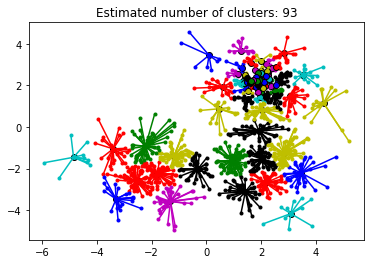

In [7]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

# DRILL: Mo' blobs, mo' problems?

You've seen how these three methods work on three blobs of reasonably separated data. Now go back and change the data. Create more or fewer blobs, and set the blobs closer together or farther apart. Set up at least three different blob configuations, then run the four methods ($k$-means, mean shift, spectral clustering and affinity propagation) on each one.  Write up a report for your mentor where you discuss what you learned about the clustering methods based on their relative performance for your different blob setups. 

## My Trials:

### Blob 1:

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
sns.set_style('darkgrid')

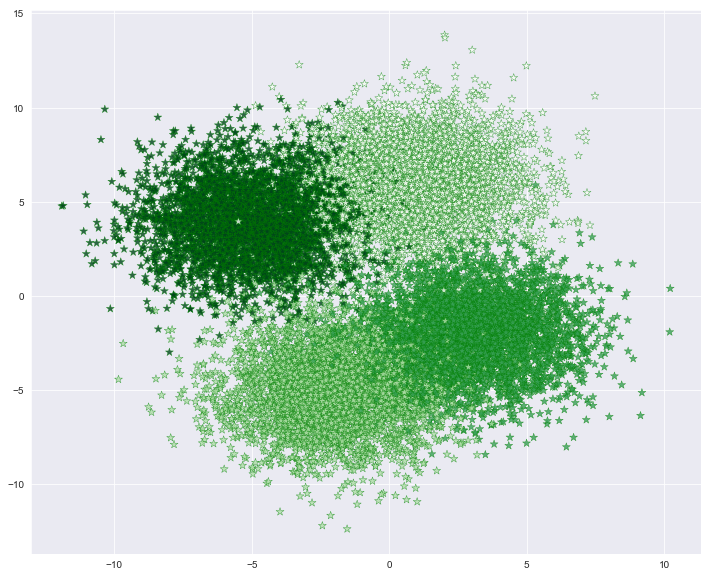

In [101]:
# Blobs: 4 - more spread out:
centers_1 = [[1, 6], [-2, -5], [3, -2], [-5, 4]]

# Make 15,000 rows worth of data with three features representing four clusters, each having an std of 2.

X, y = make_blobs(
    n_samples=15000,
    centers=centers_1,
    cluster_std=2,
    n_features=3,
    random_state=42)

plt.figure(figsize = (12, 10))
plt.scatter(X[:, 0], X[:, 1], s = 70, c=y, cmap = 'Greens', marker = '*', 
            alpha = .8, linewidth = .4, edgecolors = 'Green')
plt.show()

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

    Here, we have a dataset with four clusters, not too far apart, but not too close.  We also have 15,000 samples.  Below, we will see how our four algorithms perform and what they come up with for clusters in this context.

#### KMeans

In [102]:
KMeans_1 = KMeans(n_clusters = 4)
KMeans_1_pred_ = KMeans_1.fit_predict(X_train)

#### KMeansShift

In [103]:
bandwidth = estimate_bandwidth(X_train, quantile = .05, n_samples = 500)
KMeansShift_2 = MeanShift(bandwidth = bandwidth, bin_seeding = True)

KMeanShift_2_pred_ = KMeansShift_2.fit_predict(X_train) #.05 / 500

shift_labels = KMeansShift_2.labels_
n_clusters_ = len(np.unique(KMeansShift_2.labels_))

print(bandwidth)

1.9009377345197702


#### Spectral Clustering

In [104]:
SC_2 = SpectralClustering(n_clusters = 4)
SC_2_pred_ = SC_2.fit_predict(X_train) #hey howdy hey

#### Affinity Propagation

In [105]:
Affinity_1 = AffinityPropagation()
Affinity_1_pred_ = Affinity_1.fit_predict(X_train)

#### Graphs:

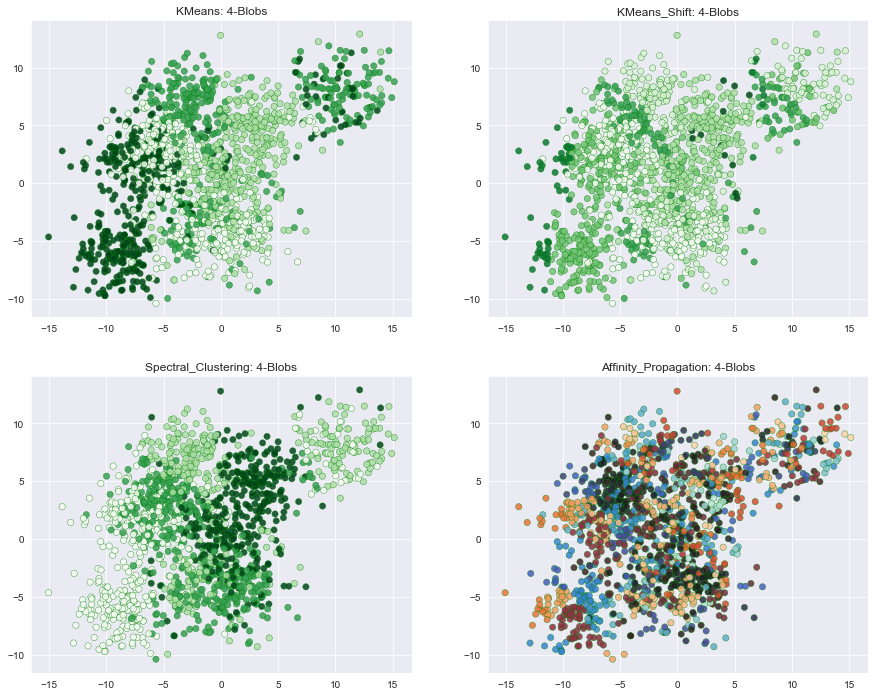

In [159]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 12))

ax1.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = KMeans_1_pred_, marker = 'o',
            cmap = 'Greens', alpha = .85, linewidth = .4, edgecolors = 'Green')
ax1.set_title('KMeans: 4-Blobs')

ax2.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = KMeanShift_2_pred_, marker = 'o',
            cmap = 'Greens', alpha = .85, linewidth = .4, edgecolors = 'Green')
ax2.set_title('KMeans_Shift: 4-Blobs')

ax3.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = SC_2_pred_, marker = 'o',
            cmap = 'Greens', alpha = .85, linewidth = .4, edgecolors = 'Green')
ax3.set_title('Spectral_Clustering: 4-Blobs')

ax4.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = Affinity_1_pred_, marker = 'o',
            cmap = 'icefire', alpha = .85, linewidth = .4, edgecolors = 'Green')
ax4.set_title('Affinity_Propagation: 4-Blobs')

plt.show()


    It looks as if our KMeans and Spectral Classification algorithms gave us a standard, vairly well-defined classification of the data: there isn't too much overlap, no outliers, and a well-defined distinction between each of the clusters.  The KMeansh shift is interesting, especially when we alter the bandwidth.  A smaller bandwidth leads to more clusters/classification groups while a large bandwidth leads to a lesser amount (classifying all the datapoints under one group if the bandwidth is large enough).  That said, the boundaries are relatively well-defined.  While this might be considered over-fitting, it could be useful for the researcher in discovering nuances to patterns, or new patterns that might not have been considered.

    Our Affinity Propagation is more difficult to sort out.  It finds lots of relationships all over the dataset, thereby casting 'cluster-nets throughout the dataset in a less-distinguishable way when compared to our previous models. While there are a handful of distinguished groups throughout the dataset, the lack of regularity could make prediction more difficult. While this demonstrates a significant amount of over-fitting, the connections between datapoints could be instrumental for the researcher in developing future studies.

### Blob 2:

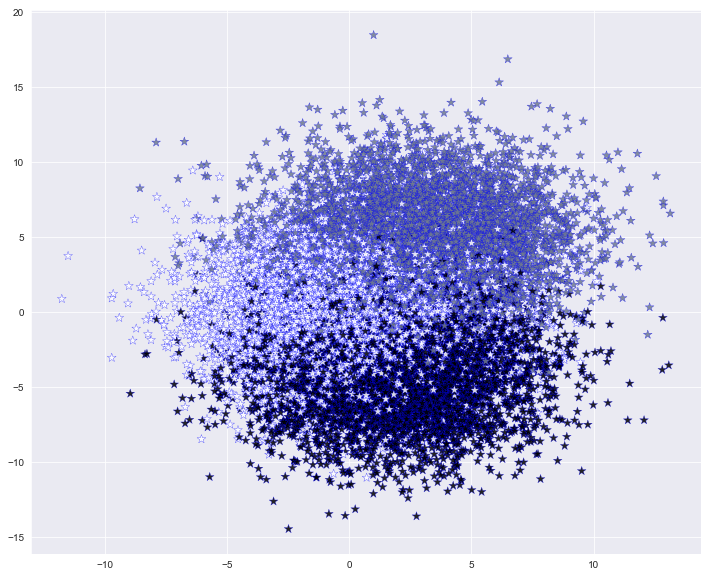

In [110]:
# Blobs: 3. Relatively close
centers_2 = [[0, 0], [3, 5], [2, -4]]

# Make 15,000 rows worth of data with 6 features representing 3 clusters, each having an std of 3.

X, y = make_blobs(
    n_samples=15000,
    centers=centers_2,
    cluster_std=3,
    n_features=6,
    random_state=42)

plt.figure(figsize = (12, 10))
plt.scatter(X[:, 0], X[:, 1], s = 85, c=y, marker = '*', cmap = 'bone_r', 
            alpha = .85, linewidth = .3, edgecolors = 'Blue')
plt.show()

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

#### KMeans

In [111]:
KMeans_2 = KMeans(n_clusters = 3)
KMeans_2_pred_ = KMeans_2.fit_predict(X_train)

#### KMeansShift

In [112]:
bandwidth = estimate_bandwidth(X_train, quantile = .02, n_samples = 500)
KMeansShift_3 = MeanShift(bandwidth = bandwidth, bin_seeding = True)

KMeanShift_3_pred_ = KMeansShift_3.fit_predict(X_train)

shift_labels = KMeansShift_3.labels_
n_clusters_ = len(np.unique(KMeansShift_3.labels_))

print(bandwidth)

1.30041828718904


#### Spectral Clustering

In [113]:
SC_3 = SpectralClustering(n_clusters = 3)
SC_3_pred_ = SC_3.fit_predict(X_train)

#### Affinity Propagation

In [114]:
Affinity_2 = AffinityPropagation()
Affinity_2_pred_ = Affinity_2.fit_predict(X_train)

#### Graphs:

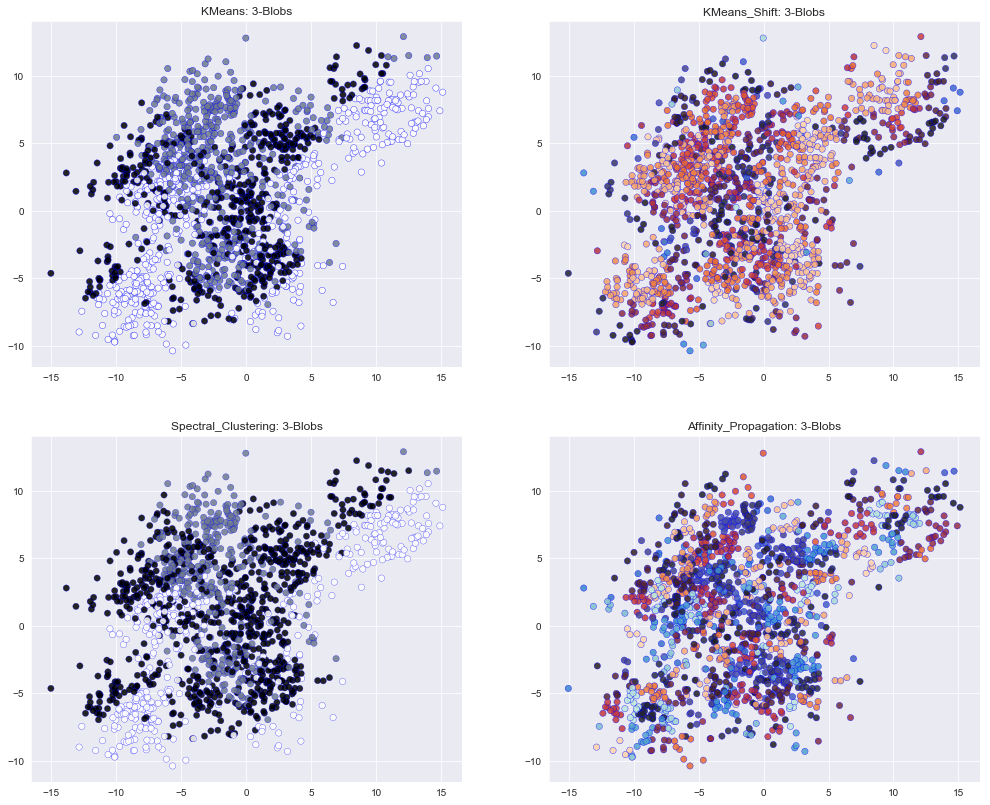

In [160]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (17, 14))

ax1.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = KMeans_2_pred_, marker = 'o',
            cmap = 'bone_r', alpha = .85, linewidth = .4, edgecolors = 'Blue')
ax1.set_title('KMeans: 3-Blobs')

ax2.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = KMeanShift_3_pred_, marker = 'o',
            cmap = 'icefire_r', alpha = .85, linewidth = .4, edgecolors = 'Blue')
ax2.set_title('KMeans_Shift: 3-Blobs')

ax3.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = SC_3_pred_, marker = 'o',
            cmap = 'bone_r', alpha = .85, linewidth = .3, edgecolors = 'Blue')
ax3.set_title('Spectral_Clustering: 3-Blobs')

ax4.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = Affinity_2_pred_, marker = 'o',
            cmap = 'icefire', alpha = .85, linewidth = .4, edgecolors = 'Blue')
ax4.set_title('Affinity_Propagation: 3-Blobs')

plt.show()


    In the above graphs, we have cluster-sets which are similar to the first set of graphs specifically in the context of KMeans and Spectral Classification.  Both graphs represent groups that are relatively well defined and easy to use for predictions.  The other two (namely KMeansShift and the Affinity Apropriation) are similar to our Affinity Propagation above: they both seem to overfit and find connections throughout the dataset when might not usually be predicted.

### Blob 3:

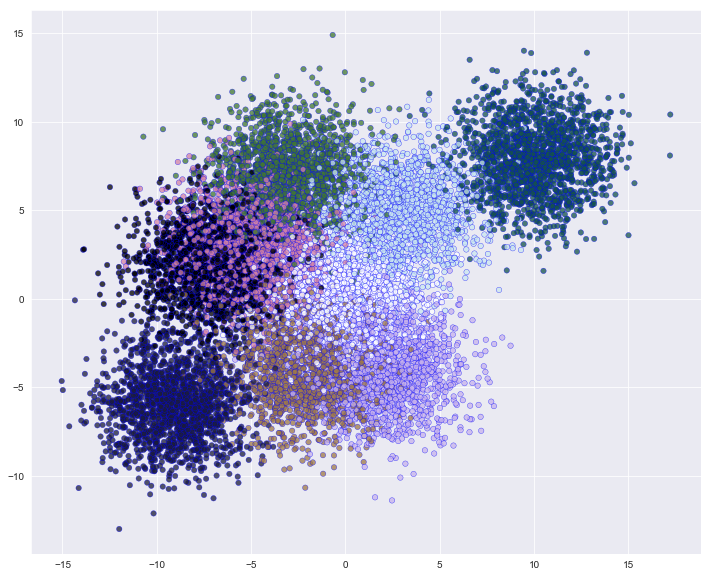

In [158]:
# Blobs: 6 - more spread out:
centers_3 = [[0, 0], [3, 5], [2, -4], [-5, 3], [-2, -4],
             [-3, 7], [10, 8], [-9, -6], [-7, 2]]

# Make 15,000 rows worth of data with 5 features representing 9 clusters, each having an std of 2.

X, y = make_blobs(
    n_samples=15000,
    centers=centers_3,
    cluster_std=2,
    n_features=5,
    random_state=42)

plt.figure(figsize = (12, 10))
plt.scatter(X[:, 0], X[:, 1], s = 30, c=y, marker = 'o', cmap = 'cubehelix_r', 
            alpha = .75, linewidth = .4, edgecolors = 'Blue')
plt.show()

#Divide into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.9,
    random_state=42)

#### KMeans

In [146]:
KMeans_3 = KMeans(n_clusters = 9)
KMeans_3_pred_ = KMeans_3.fit_predict(X_train)

#### KMeansShift

In [147]:
bandwidth = estimate_bandwidth(X_train, quantile = .02, n_samples = 500)
KMeansShift_4 = MeanShift(bandwidth = bandwidth, bin_seeding = True)

KMeanShift_4_pred_ = KMeansShift_4.fit_predict(X_train)

shift_labels = KMeansShift_4.labels_
n_clusters_ = len(np.unique(KMeansShift_4.labels_))

print(bandwidth)

1.462131228945677


#### Spectral Clustering

In [148]:
SC_4 = SpectralClustering(n_clusters = 9)
SC_4_pred_ = SC_4.fit_predict(X_train)

#### Affinity Propagation

In [149]:
Affinity_3 = AffinityPropagation()
Affinity_3_pred_ = Affinity_3.fit_predict(X_train)

#### Graphs:

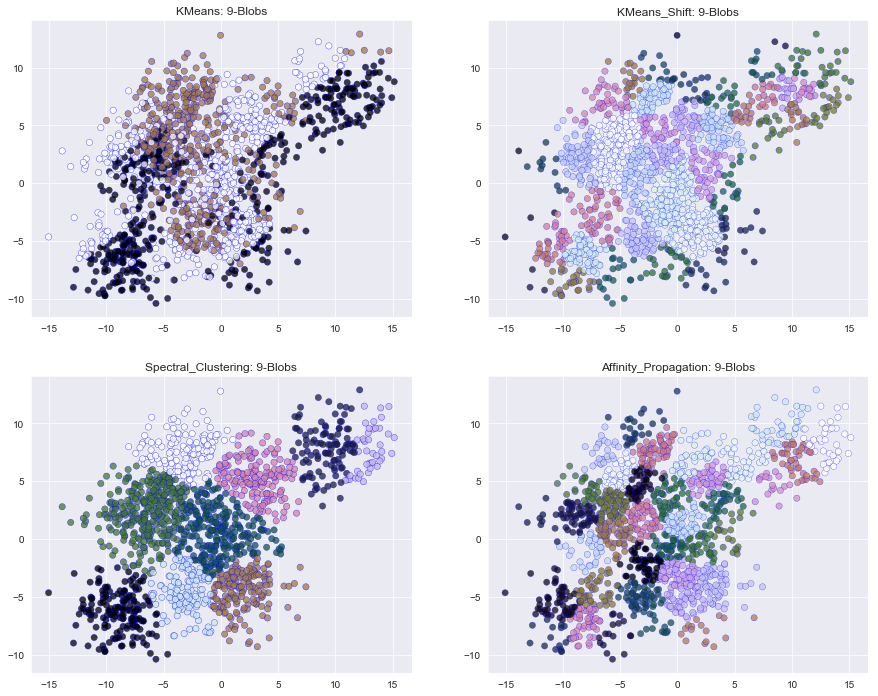

In [161]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15, 12))

ax1.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = KMeans_2_pred_, marker = 'o',
            cmap = 'cubehelix', alpha = .75, linewidth = .4, edgecolors = 'Blue')
ax1.set_title('KMeans: 9-Blobs')

ax2.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = KMeanShift_4_pred_, marker = 'o',
            cmap = 'cubehelix_r', alpha = .75, linewidth = .3, edgecolors = 'Blue')
ax2.set_title('KMeans_Shift: 9-Blobs')

ax3.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = SC_4_pred_, marker = 'o',
            cmap = 'cubehelix', alpha = .75, linewidth = .4, edgecolors = 'Blue')
ax3.set_title('Spectral_Clustering: 9-Blobs')

ax4.scatter(x = X_train[:, 0], y = X_train[:, 1], s = 40, c = Affinity_3_pred_, marker = 'o',
            cmap = 'cubehelix', alpha = .75, linewidth = .3, edgecolors = 'Blue')
ax4.set_title('Affinity_Propagation: 9-Blobs')
plt.show()


    Here, as the cluster amount increases, we see our Spectral algorithm resembling our previous Affinity classifications (i.e. more datapoints in different clusters, less definition (albeit slight)).  Interestingly enough, our KMeans algorithm is no longer as reliable (from a prediction standpoint) as the others and only includes three classifications (not necessarily a bad thing, but depends on the context you are working in).  Three classifications, as opposed to nine, would provide less over-fitting, and more of a global perspective, but your distinctions between classes could be difficult to make sense of. 